In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [ ]:
data_dir = "/content/oasis_dataset/Data"


In [ ]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f"📁 Directory: {root}")
        print(f"   📄 Files: {files[:5]}")  # Display first 5 files for each directory
        print()


📁 Directory: /content/oasis_dataset/Data/Moderate Dementia
   📄 Files: ['OAS1_0351_MR1_mpr-4_117.jpg', 'OAS1_0308_MR1_mpr-4_145.jpg', 'OAS1_0351_MR1_mpr-3_118.jpg', 'OAS1_0351_MR1_mpr-4_143.jpg', 'OAS1_0351_MR1_mpr-3_152.jpg']

📁 Directory: /content/oasis_dataset/Data/Very mild Dementia
   📄 Files: ['OAS1_0380_MR1_mpr-2_105.jpg', 'OAS1_0015_MR1_mpr-2_102.jpg', 'OAS1_0066_MR1_mpr-2_106.jpg', 'OAS1_0243_MR1_mpr-3_137.jpg', 'OAS1_0016_MR1_mpr-2_120.jpg']

📁 Directory: /content/oasis_dataset/Data/Mild Dementia
   📄 Files: ['OAS1_0031_MR1_mpr-3_130.jpg', 'OAS1_0373_MR1_mpr-2_134.jpg', 'OAS1_0052_MR1_mpr-3_118.jpg', 'OAS1_0122_MR1_mpr-3_123.jpg', 'OAS1_0134_MR1_mpr-4_116.jpg']

📁 Directory: /content/oasis_dataset/Data/Non Demented
   📄 Files: ['OAS1_0227_MR1_mpr-1_118.jpg', 'OAS1_0117_MR2_mpr-3_144.jpg', 'OAS1_0241_MR1_mpr-2_156.jpg', 'OAS1_0038_MR1_mpr-3_123.jpg', 'OAS1_0253_MR1_mpr-4_104.jpg']



# Data preprocessing

In [ ]:
import os
import random
import shutil

sample_size_per_class = 20000
original_dir = "/content/oasis_dataset/Data"
sample_dir = "/content/oasis_dataset/sample_data"


os.makedirs(sample_dir, exist_ok=True)

for class_dir in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_dir)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    num_to_sample = min(sample_size_per_class, len(images))
    sample_images = random.sample(images, num_to_sample)

    class_sample_dir = os.path.join(sample_dir, class_dir)
    os.makedirs(class_sample_dir, exist_ok=True)

    for image in sample_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(class_sample_dir, image)
        shutil.copy(src, dst)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 128, 128
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}


Found 31373 images belonging to 4 classes.
Found 7842 images belonging to 4 classes.


# model 1 two conv layers,dropouts,and one fully connected layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, Input
#model 1 two conv layers one fully connected and dropouts
inputs = Input(shape=(img_height, img_width, 3))

x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(train_gen.class_indices), activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 194s 192ms/step - accuracy: 0.5218 - loss: 1.0227 - val_accuracy: 0.5844 - val_loss: 0.9438
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 183s 186ms/step - accuracy: 0.6197 - loss: 0.8477 - val_accuracy: 0.5530 - val_loss: 0.8964
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 183s 187ms/step - accuracy: 0.6384 - loss: 0.8145 - val_accuracy: 0.6146 - val_loss: 0.8197
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 187s 191ms/step - accuracy: 0.6360 - loss: 0.8085 - val_accuracy: 0.6157 - val_loss: 0.8064
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 192s 196ms/step - accuracy: 0.6503 - loss: 0.7879 - val_accuracy: 0.5895 - val_loss: 0.8282
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 195s 199ms/step - accuracy: 0.6531 - loss: 0.7867 - val_accuracy: 0.6196 - val_loss: 0.8456
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 185s 189ms/step - accuracy: 0.6542 - loss: 0.7727 - val_accuracy: 0.6004 - val_loss: 0.8039
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 181s 184ms/step - accuracy: 0.6544 -

# evaluation

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.6411 - loss: 0.7686
Validation Loss: 0.7745
Validation Accuracy: 0.6403


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


246/246 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.19      0.00      0.01      1000
 Moderate Dementia       0.00      0.00      0.00        97
      Non Demented       0.50      0.47      0.49      4000
Very mild Dementia       0.34      0.50      0.40      2745

          accuracy                           0.42      7842
         macro avg       0.26      0.24      0.22      7842
      weighted avg       0.40      0.42      0.39      7842

Confusion Matrix:
 [[   3    0  480  517]
 [   0    0   52   45]
 [   7    0 1894 2099]
 [   6    0 1368 1371]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# explainability techniques

lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

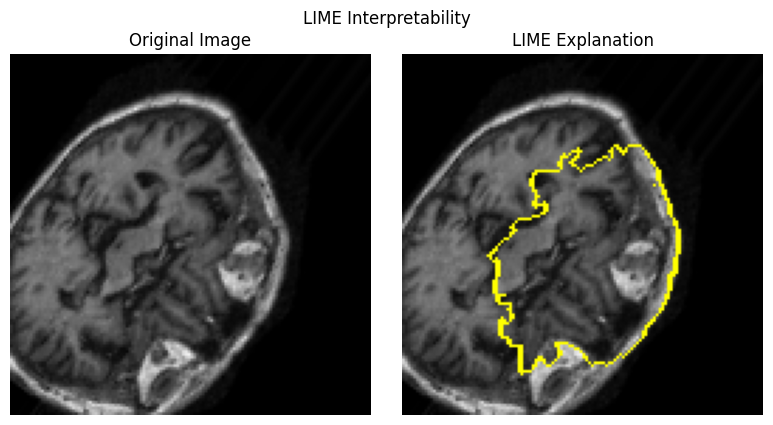

In [ ]:

!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
val_images, val_labels = next(val_gen)

image = val_images[0]


def predict_fn(images):
    return model.predict(images)

# Explain the prediction
explanation = explainer.explain_instance(
    image.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.tight_layout()
plt.suptitle("LIME Interpretability", y=1.05)
plt.show()


Shap

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(32, 128, 128, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(64, 128, 128, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 128, 128, 3

Shape of shap_values: 1, (128, 128, 3, 4)


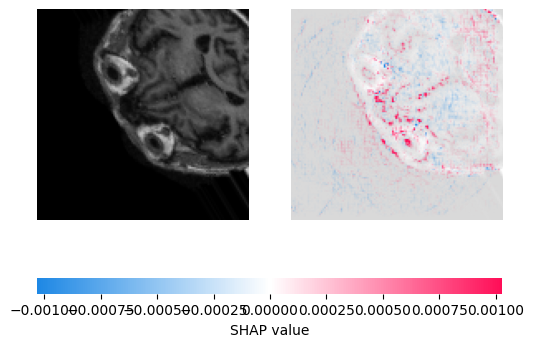

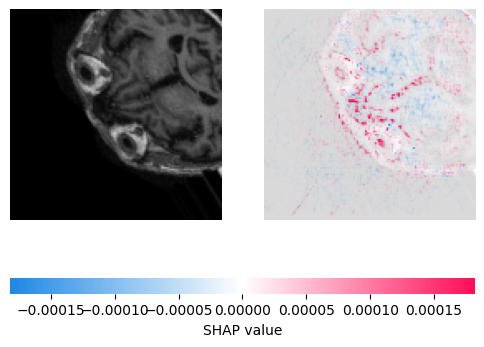

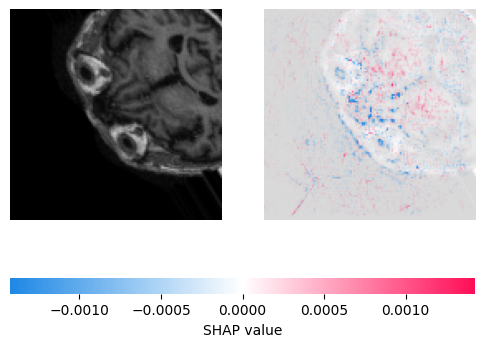

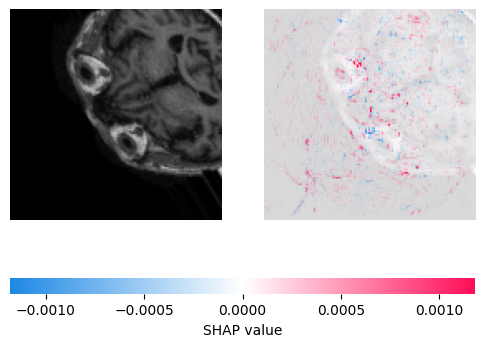

In [ ]:
import shap
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
image_batch, label_batch =next(val_gen)

image_idx = np.random.randint(0, len(image_batch))
image_to_explain = image_batch[image_idx]

explainer = shap.DeepExplainer(model, image_batch[:100])

shap_values = explainer.shap_values(image_to_explain.reshape(1, img_height, img_width, 3))

print(f"Shape of shap_values: {len(shap_values)}, {shap_values[0].shape if len(shap_values) > 0 else 'None'}")


if len(shap_values) > 0:
    for class_idx in range(shap_values[0].shape[-1]):
        shap.image_plot([shap_values[0][:, :, :, class_idx]], image_to_explain)
else:
    print("No SHAP values available for visualization.")


Grad-Cam

In [ ]:
input_image = image_to_explain[0]
if input_image.shape[-1] == 1:
    input_image = np.repeat(input_image, 3, axis=-1)
input_image = input_image / np.max(input_image)

In [ ]:
import cv2
import tensorflow as tf
def grad_cam(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradient is None. Check the model and inputs.")
        return np.zeros((image.shape[1], image.shape[2]))

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap)
    if max_val == 0:
        print("Heatmap is all zeros after ReLU.")
        return np.zeros((image.shape[1], image.shape[2]))

    heatmap /= max_val
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))  # No need to call `.numpy()` here
    return heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


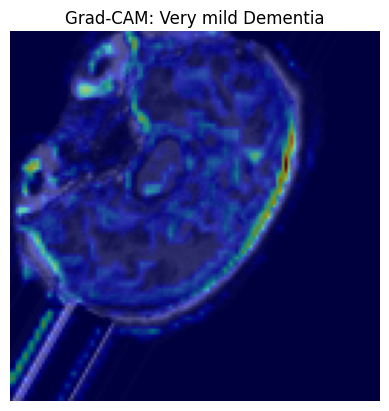

In [ ]:
image_batch, label_batch = next(val_gen)
image_idx = np.random.randint(0, image_batch.shape[0])
image_to_explain = np.expand_dims(image_batch[image_idx], axis=0)

predicted_class_idx = np.argmax(model.predict(image_to_explain))

heatmap = grad_cam(model, image_to_explain, predicted_class_idx, last_conv_layer_name='conv2d_1')

plt.imshow(image_to_explain[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.show()


sailency map

In [ ]:
def saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.cast(image_tensor, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor, training=False)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image_tensor)

    if grads is None:
        print("Gradients are None.")
        return np.zeros((image.shape[1], image.shape[2]))


    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    saliency = saliency.numpy()
    max_val = np.max(saliency)
    if max_val == 0:
        print("Saliency map still all zeros.")
        return np.zeros((image.shape[1], image.shape[2]))

    saliency /= max_val
    return saliency


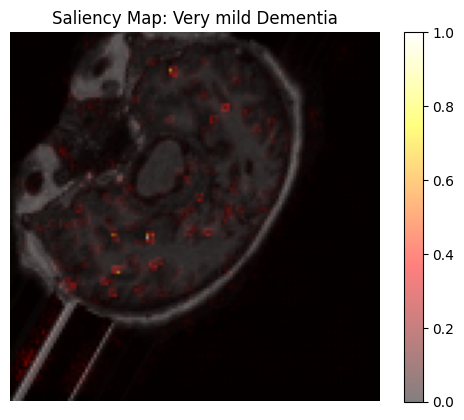

In [ ]:
saliency = saliency_map(model, image_to_explain, predicted_class_idx)

plt.imshow(image_to_explain[0])
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.title(f"Saliency Map: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.colorbar()
plt.show()